In [5]:
import sys
sys.path.append(r'C:\Users\Jameshuckle\Dropbox\My-Portfolio\AlgorithmicTrading\utils')
from trading_util import (download_data_local_check, prep_stock_data, prep_fx_data, calc_sharpe, calc_romad)

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import os

pd.options.display.max_columns = 100
%matplotlib inline

In [2]:
data_source = 'fx' # 'fx', 'stock'

if data_source == 'fx':
    ### FX data #######
    fx_files = [
                 'EURUSD_1h_2003-2010.csv', 'EURUSD_1h_2010-2020.csv',
                 'USDJPY_1h_2003-2010.csv', 'USDJPY_1h_2010-2020.csv',
                 'NZDUSD_1h_2003-2020.csv',
                 'AUDUSD_1h_2003-2020.csv',
                 'USDCAD_1h_2003-2020.csv',
                 ]

    loaded_files = prep_fx_data(fx_files)
        
if data_source == 'stock':
    ### stock data ######
    start = '2000-01-01'
    end = '2020-04-28'
    ## download data
    all_stock_data = download_data_local_check('SP500', start, end)
    loaded_files = prep_stock_data(all_stock_data, filter_start_date_tuple=None) #(2015,1,1)

EURUSD_1h_2003-2010.csv
EURUSD_1h_2010-2020.csv
USDJPY_1h_2003-2010.csv
USDJPY_1h_2010-2020.csv
NZDUSD_1h_2003-2020.csv
AUDUSD_1h_2003-2020.csv
USDCAD_1h_2003-2020.csv


In [9]:
import copy

def resample_data(data, period='1H'):
    data = data.set_index('Gmt time')
    data = data.resample(period).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'})
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    return data  

def calc_returns(data, cumulative=False):
    data['return'] = (data['Close'] - data['Open']) / data['Open']
    for i in range(1, lags):
        data[f'return{i}'] = data['return'].shift(-i)
    data.dropna(inplace=True)
    
    if cumulative:
        return_cols = [f'return{i}' for i in range(1, lags)]
        data[return_cols] = data[return_cols].cumsum(axis=1)  
    return data

def add_filter(data, small_filter, big_filter, ma_len, print_out=False):
    skip = False 
    data['filter'] = abs(data['return']).rolling(window=ma_len, min_periods=ma_len).mean()
    data.dropna(inplace=True)
    filter_point = data['filter']
    data = data[(abs(data['return']) > filter_point * small_filter) & (abs(data['return']) < filter_point * big_filter)]
    if len(data) == 0:
        print('no data left after applied filters, skip')
        skip = True
    if print_out:
        print('mean_return:', round(filter_point.mean(),6), 'filter_size:', round(filter_size.mean(),6),
              'no. points',len(data))
    return data, skip

def auto_corrs(data):
    autocorrs = {}
    for i in range(1, lags):
        #auto = data['return'].autocorr(trade_lag=-i)  # if you wanted to run autocorr with just itself (wont work with cumulative)
        auto = np.corrcoef(x=data['return'], y=data[f'return{i}'])[0][1]
        autocorrs[i] = auto
    return autocorrs

def plot_boxplot(autocor_dict):
    box_data = pd.DataFrame(autocor_dict).transpose()
    ax = box_data.boxplot(figsize=(12,8), showfliers=False)
    ax.grid(False)
    ax.axhline(0, c='k')
    ax.set_ylabel('correlation')
    ax.set_xlabel('lag')
    title = 'Cumulative Autocorrelations' if cumulative_autocorrs else 'Autocorrelations'
    ax.set_title(title)
    plt.rcParams.update({'font.size': 14})
    plt.show()
    
def calc_trades(all_trades, pip_fees=1):
    trades = pd.concat(all_trades, axis=0).reset_index(drop=True)
    trades.set_index('Gmt time', drop=True, inplace=True)
    trades.columns = ['return']

    if pip_fees:
        trades -= (10 ** -4) * pip_fees
    avg_profit_pip = trades['return'].mean()
    
    trades = trades.groupby('Gmt time').sum()['return']
    return trades, avg_profit_pip

def calc_autocorrs():
    ###############################################
    all_auto_corrs = {}
    all_trades = {}
    timestamps = []
    loaded_files_copy = copy.deepcopy(loaded_files)
    for file, data in loaded_files_copy.items():
        data = data.reset_index()
        if resample_period:
            data = resample_data(data, resample_period)
        data = calc_returns(data, cumulative=cumulative_autocorrs)
        if apply_filters:
            data, skip = add_filter(data, small_filter, big_filter, ma_len, print_out=False)
            if skip: continue
        autocorrs = auto_corrs(data)
        all_auto_corrs[file] = autocorrs

        # Update trade values
        signal = f'return{trade_lag}'
        shorts = data['return'] > 0
        data = data.copy()
        data.loc[shorts, signal] *= -1
        all_trades[file] = data[['Gmt time', signal]]
    ######################################################
    if box_plot: plot_boxplot(all_auto_corrs)
    trades, avg_profit_pip = calc_trades(all_trades, pip_fees=pip_fees)
    trades = trades.resample('1D').sum()
    sharpe = calc_sharpe(trades)
    romad = calc_romad(trades, filter_large_trades=0.5, plot=equity_chart)

    if equity_chart: 
        print('avg_profit_pip:', avg_profit_pip)
        print('sharpe:', sharpe)
    
    return all_trades, all_auto_corrs, avg_profit_pip, sharpe, romad

## Calc autocorrelations with bar size filters (cumulative=True)

In [26]:
pd.options.mode.chained_assignment = 'raise'

##### vars ############
resample_period='1D' #'4H','1D'
cumulative_autocorrs = True # sum the effect over multiple bars, rather than individual lags
lags = 20
pip_fees = 1
box_plot = False
equity_chart = False
trade_lag = 4 # if equity chart == True
##
apply_filters = True
small_filter = 2.5
big_filter = 3
ma_len = 720
########################

##  Run brute force search ####
avg_profits = {}
for ma_len in tqdm(range(100,2200,500)):
    for trade_lag in range(2,8,1):
        for small_filter in np.arange(1,4,1):
            for big_filter in np.arange(2,8,2):
                if small_filter >= big_filter:
                    continue
                all_trades, all_auto_corrs, avg_profit_pip, sharpe, romad = calc_autocorrs()
                print('small_filter', small_filter, 'big_filter', big_filter, 'trade_lag', trade_lag, 'ma', ma_len)
                avg_profits[(small_filter, big_filter, trade_lag, ma_len)] = (avg_profit_pip, romad)
 
avg_profits  

small_filter 1 big_filter 2 trade_lag 2 ma 100
small_filter 1 big_filter 4 trade_lag 2 ma 100
small_filter 1 big_filter 6 trade_lag 2 ma 100
small_filter 2 big_filter 4 trade_lag 2 ma 100
small_filter 2 big_filter 6 trade_lag 2 ma 100
small_filter 3 big_filter 4 trade_lag 2 ma 100
small_filter 3 big_filter 6 trade_lag 2 ma 100
small_filter 1 big_filter 2 trade_lag 3 ma 100
small_filter 1 big_filter 4 trade_lag 3 ma 100
small_filter 1 big_filter 6 trade_lag 3 ma 100
small_filter 2 big_filter 4 trade_lag 3 ma 100
small_filter 2 big_filter 6 trade_lag 3 ma 100
small_filter 3 big_filter 4 trade_lag 3 ma 100
small_filter 3 big_filter 6 trade_lag 3 ma 100
small_filter 1 big_filter 2 trade_lag 4 ma 100
small_filter 1 big_filter 4 trade_lag 4 ma 100
small_filter 1 big_filter 6 trade_lag 4 ma 100
small_filter 2 big_filter 4 trade_lag 4 ma 100
small_filter 2 big_filter 6 trade_lag 4 ma 100
small_filter 3 big_filter 4 trade_lag 4 ma 100
small_filter 3 big_filter 6 trade_lag 4 ma 100
small_filter 

small_filter 1 big_filter 4 trade_lag 2 ma 2100
no data left after applied filters, skip
no data left after applied filters, skip
small_filter 1 big_filter 6 trade_lag 2 ma 2100
no data left after applied filters, skip
no data left after applied filters, skip
small_filter 2 big_filter 4 trade_lag 2 ma 2100
no data left after applied filters, skip
no data left after applied filters, skip
small_filter 2 big_filter 6 trade_lag 2 ma 2100
no data left after applied filters, skip
no data left after applied filters, skip
small_filter 3 big_filter 4 trade_lag 2 ma 2100
no data left after applied filters, skip
no data left after applied filters, skip
small_filter 3 big_filter 6 trade_lag 2 ma 2100
no data left after applied filters, skip
no data left after applied filters, skip
small_filter 1 big_filter 2 trade_lag 3 ma 2100
no data left after applied filters, skip
no data left after applied filters, skip
small_filter 1 big_filter 4 trade_lag 3 ma 2100
no data left after applied filters, skip
n

{(1, 2, 2, 100): (8.650031514431379e-05, 0.04),
 (1, 4, 2, 100): (-0.00013020025448587703, -0.05),
 (1, 6, 2, 100): (-0.0001374204742034797, -0.04),
 (2, 4, 2, 100): (-0.0005720325091563093, -0.04),
 (2, 6, 2, 100): (-0.0005593764103860543, -0.03),
 (3, 4, 2, 100): (-0.00037316738117896934, -0.03),
 (3, 6, 2, 100): (-0.0003815587399313586, -0.01),
 (1, 2, 3, 100): (0.00020005212200967123, 0.05),
 (1, 4, 3, 100): (-5.761511068643958e-05, -0.02),
 (1, 6, 3, 100): (-5.916607471979118e-05, -0.01),
 (2, 4, 3, 100): (-0.0005829745713057446, -0.02),
 (2, 6, 3, 100): (-0.0005476363824349531, -0.03),
 (3, 4, 3, 100): (-0.0002637396267080444, -0.0),
 (3, 6, 3, 100): (-0.00022499159501610357, -0.01),
 (1, 2, 4, 100): (0.000277039424317787, 0.16),
 (1, 4, 4, 100): (3.635922237879244e-05, -0.02),
 (1, 6, 4, 100): (3.26631144207943e-05, -0.03),
 (2, 4, 4, 100): (-0.00045436526652640634, -0.02),
 (2, 6, 4, 100): (-0.00042783916821125136, -0.03),
 (3, 4, 4, 100): (-0.0002885400120242773, -0.03),
 (3, 

In [36]:
#all_data = pd.read_csv(autocorrs_fx_daily') #'autocorrs_fx_hourly'

In [29]:
all_data_final = pd.DataFrame(avg_profits).transpose()
all_data_final.index.rename(('small_filter','big_filter','trade_lag','ma_len'), inplace=True)#.sort_values(ascending=False)
all_data_final.columns = ['avg_profit_pip','romad']
all_data_final.sort_values('romad', ascending=False)

avg_profit_pip  romad
small_filter big_filter trade_lag ma_len                       
1            2          4         100           0.000277   0.16
                        7         600           0.000243   0.13
                        6         100           0.000248   0.12
                        5         2100          0.000058   0.10
                        4         600           0.000113   0.09
...                                                  ...    ...
3            4          4         1600         -0.000776  -0.08
             6          4         2100         -0.001198  -0.08
                        5         2100         -0.001524  -0.09
1            6          2         600          -0.000145  -0.09
3            4          6         1600         -0.000423  -0.09

[210 rows x 2 columns]

In [ ]:
for variable in ['small_filter','big_filter','trade_lag','ma_len']:
    all_data_final.groupby(variable).agg({'avg_profit_pip':'max','romad':'max'}).plot(title=variable)

In [ ]:
trades = pd.DataFrame(all_trades)
print(trades.sum().sum())
trades.sum(axis=0)

#### Winner (0.5 pip fee)

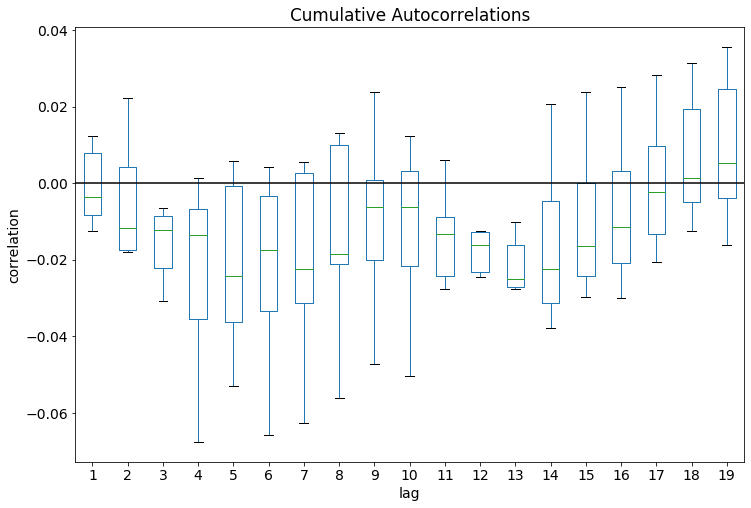

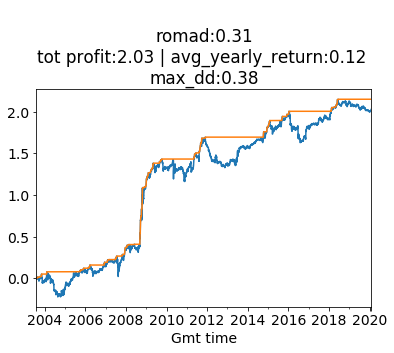

avg_profit_pip: 9.667988536245756e-05
sharpe: 0.48


In [34]:
###### vars ############
resample_period=None #'4H','1D'
cumulative_autocorrs = True # sum the effect over multiple bars, rather than individual lags
lags = 20
pip_fees = 0 #0.5
box_plot = True
equity_chart = True
trade_lag = 6 # if equity chart == True
##
apply_filters = True
small_filter = 3
big_filter = 6
ma_len = 1600
########################

all_trades, all_auto_corrs, avg_profit_pip, sharpe, romad = calc_autocorrs()

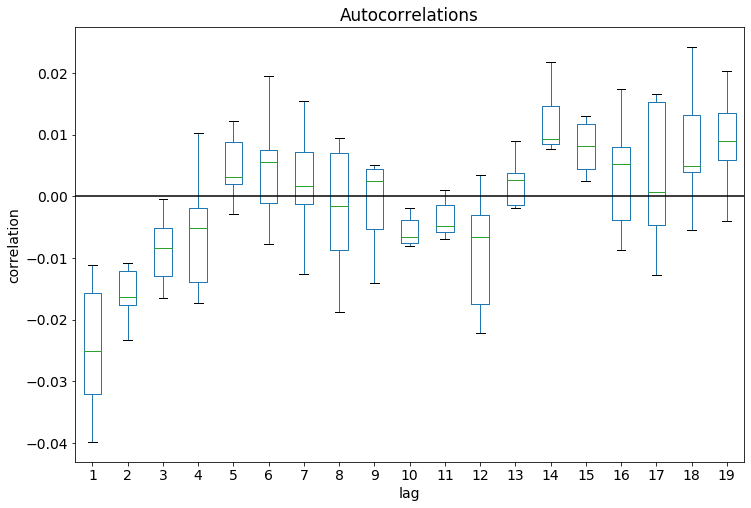

In [14]:
###### vars ############
resample_period=None #'4H','1D'
cumulative_autocorrs = False # sum the effect over multiple bars, rather than individual lags
lags = 20
pip_fees = 0.5
box_plot = True
equity_chart = False
trade_lag = 4 # if equity chart == True
##
apply_filters = True
small_filter = 1
big_filter = 4
ma_len = 100
########################

all_trades, all_auto_corrs, avg_profit_pip, sharpe, romad = calc_autocorrs()

### Auto corrs, no filters

#### 1H

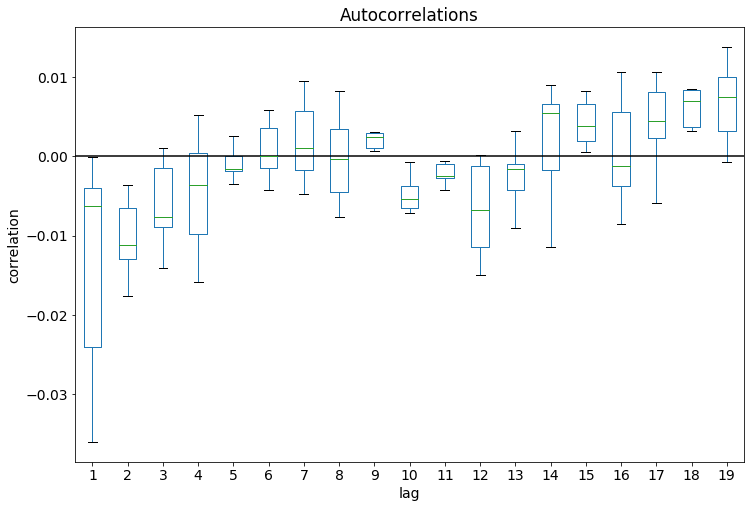

In [15]:
###### vars ############
resample_period=None #'4H','1D'
cumulative_autocorrs = False # sum the effect over multiple bars, rather than individual lags
lags = 20
pip_fees = 0
box_plot = True
equity_chart = False
trade_lag = 4 # if equity chart == True
##
apply_filters = False
small_filter = 2.5
big_filter = 3
ma_len = 720
########################

all_trades, all_auto_corrs, avg_profit_pip, sharpe, romad = calc_autocorrs()

#### 4H

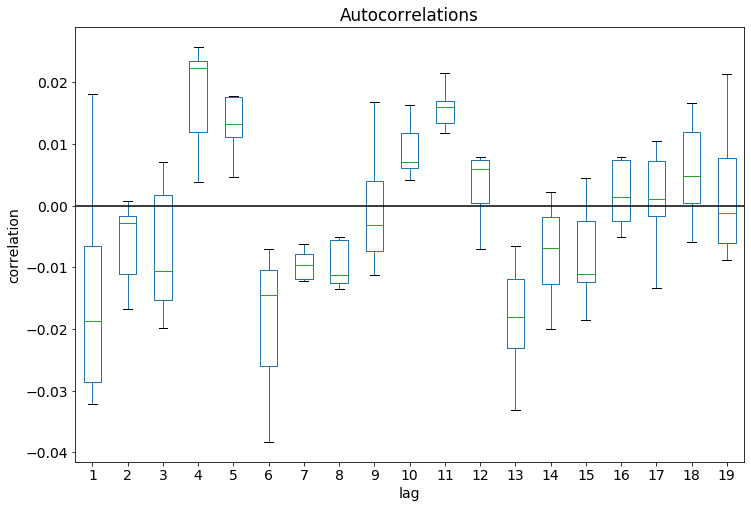

In [16]:
###### vars ############
resample_period='4H' #'4H','1D'
cumulative_autocorrs = False # sum the effect over multiple bars, rather than individual lags
lags = 20
pip_fees = 0
box_plot = True
equity_chart = False
trade_lag = 4 # if equity chart == True
##
apply_filters = False
small_filter = 2.5
big_filter = 3
ma_len = 720
########################

all_trades, all_auto_corrs, avg_profit_pip, sharpe, romad = calc_autocorrs()

#### 1D

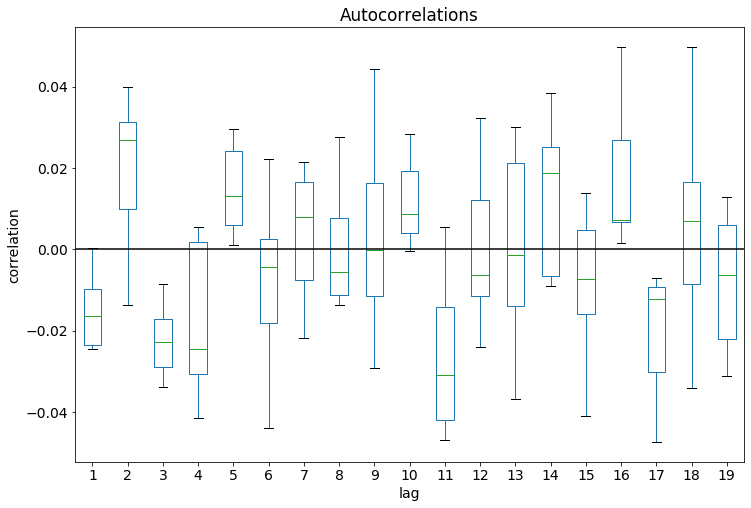

In [17]:
###### vars ############
resample_period='1D' #'4H','1D'
cumulative_autocorrs = False # sum the effect over multiple bars, rather than individual lags
lags = 20
pip_fees = 0
box_plot = True
equity_chart = False
trade_lag = 4 # if equity chart == True
##
apply_filters = False
small_filter = 2.5
big_filter = 3
ma_len = 720
########################

all_trades, all_auto_corrs, avg_profit_pip, sharpe, romad = calc_autocorrs()

#### 1 Week

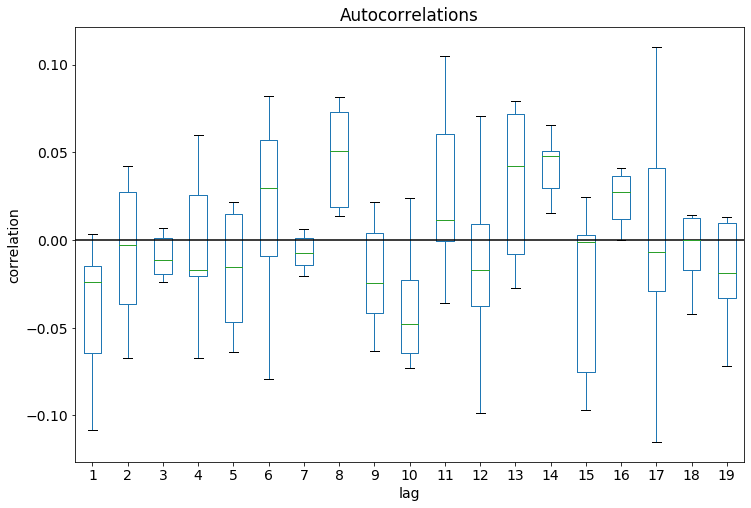

In [18]:
###### vars ############
resample_period='1W' #'4H','1D'
cumulative_autocorrs = False # sum the effect over multiple bars, rather than individual lags
lags = 20
pip_fees = 0
box_plot = True
equity_chart = False
trade_lag = 4 # if equity chart == True
##
apply_filters = False
small_filter = 2.5
big_filter = 3
ma_len = 720
########################

all_trades, all_auto_corrs, avg_profit_pip, sharpe, romad = calc_autocorrs()

### Cumalitive autcorrelation with filters

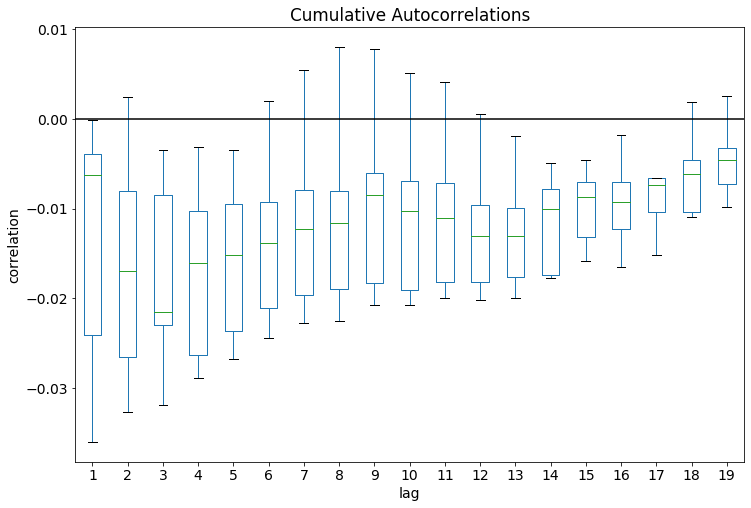

In [19]:
###### vars ############
resample_period=None #'4H','1D'
cumulative_autocorrs = True # sum the effect over multiple bars, rather than individual lags
lags = 20
pip_fees = 0
box_plot = True
equity_chart = False
trade_lag = 4 # if equity chart == True
##
apply_filters = False
small_filter = 1
big_filter = 4
ma_len = 100
########################

all_trades, all_auto_corrs, avg_profit_pip, sharpe, romad = calc_autocorrs()

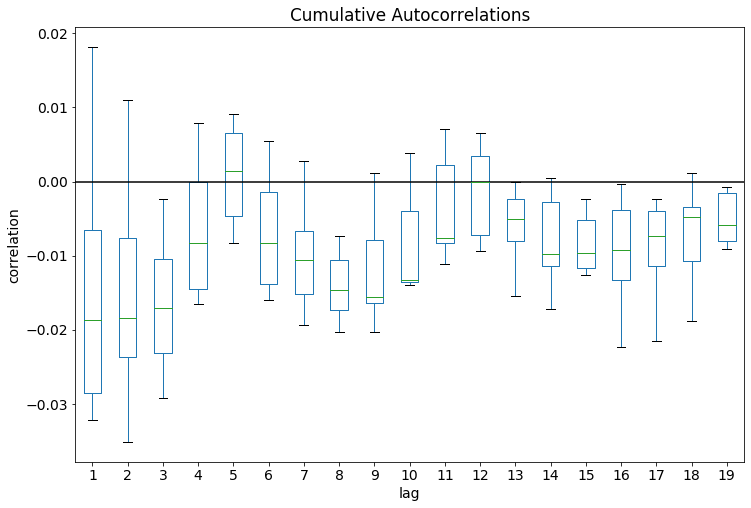

In [20]:
###### vars ############
resample_period='4H' #'4H','1D'
cumulative_autocorrs = True # sum the effect over multiple bars, rather than individual lags
lags = 20
pip_fees = 0
box_plot = True
equity_chart = False
trade_lag = 4 # if equity chart == True
##
apply_filters = False
small_filter = 2.5
big_filter = 3
ma_len = 720
########################

all_trades, all_auto_corrs, avg_profit_pip, sharpe, romad = calc_autocorrs()